In [6]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Number of samples
n_samples = 5000

# Features
lam_temp = np.random.normal(90, 10, n_samples)        # mean 90°C, small variation, 70-110
lam_pressure = np.random.normal(550, 50, n_samples)   # mean 550 N, 400-700 N
long_side_sealer_temp  = np.random.normal(180, 5, n_samples) # mean 180, 150-200
short_side_sealer_temp = np.random.normal(180, 5, n_samples) # mean 180, 150-200
long_side_sealer_pressure  = np.random.normal(500, 30, n_samples) # mean 500, 400-600 N
short_side_sealer_pressure = np.random.normal(500, 30, n_samples) # mean 500, 400-600 N
heater_temp = np.random.normal(80, 5, n_samples) # mean 80, 60-100


# Defect probability model
prob_defect = np.zeros(n_samples)

# Lamination temperature (too low → poor adhesion, wrinkles; too high → thermal damage)
prob_defect += (lam_temp < 85) * 0.25
prob_defect += (lam_temp > 100) * 0.15

# Lamination pressure (too low → weak bonding; too high → material damage)
prob_defect += (lam_pressure < 480) * 0.20
prob_defect += (lam_pressure > 620) * 0.15

# Sealing temperatures (too low → poor sealing; too high → burn-through)
prob_defect += ((short_side_sealer_temp < 170) | (long_side_sealer_temp < 170)) * 0.25
prob_defect += ((short_side_sealer_temp > 190) | (long_side_sealer_temp > 190)) * 0.15

# Sealing pressures (too low → incomplete seal; too high → misalignment / deformation)
prob_defect += ((short_side_sealer_pressure < 470) | (long_side_sealer_pressure < 470)) * 0.20
prob_defect += ((short_side_sealer_pressure > 550) | (long_side_sealer_pressure > 550)) * 0.15

# Heater temperature (too low → non-uniform heating; too high → film shrinkage)
prob_defect += (heater_temp < 70) * 0.20
prob_defect += (heater_temp > 90) * 0.15

# Add random noise
prob_defect += np.random.normal(0, 0.05, n_samples)
prob_defect = np.clip(prob_defect, 0, 1)

# Generate binary defect label
defect = np.random.binomial(1, prob_defect)

# Build dataframe
df = pd.DataFrame({
     "lam_temp": lam_temp,
        "lam_pressure": lam_pressure,
        "long_side_sealer_temp": long_side_sealer_temp,
        "short_side_sealer_temp": short_side_sealer_temp,
        "long_side_sealer_pressure": long_side_sealer_pressure,
        "short_side_sealer_pressure": short_side_sealer_pressure,
        "heater_temp": heater_temp,
        "defect": defect
})

print(df.head())

     lam_temp  lam_pressure  long_side_sealer_temp  short_side_sealer_temp  \
0   94.967142    528.812016             176.607526              179.282884   
1   88.617357    527.329295             178.472503              179.836720   
2   96.476885    460.217841             177.013095              180.321474   
3  105.230299    533.495490             180.552090              184.734307   
4   87.658466    586.641454             185.985893              176.263913   

   long_side_sealer_pressure  short_side_sealer_pressure  heater_temp  defect  
0                 510.448587                  505.126206    70.097140       0  
1                 508.499708                  500.367663    74.725072       0  
2                 471.904405                  487.065348    77.064858       0  
3                 517.387527                  499.924200    80.748345       0  
4                 455.297520                  514.725249    85.120812       0  


In [11]:
# --------------------------
# Train the classifier
# --------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       745
           1       0.42      0.06      0.10       255

    accuracy                           0.74      1000
   macro avg       0.58      0.52      0.48      1000
weighted avg       0.67      0.74      0.66      1000



              precision    recall  f1-score   support

           0       0.76      0.96      0.84       745
           1       0.43      0.10      0.16       255

    accuracy                           0.74      1000
   macro avg       0.59      0.53      0.50      1000
weighted avg       0.67      0.74      0.67      1000



/tmp/ipython-input-422765181.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis")


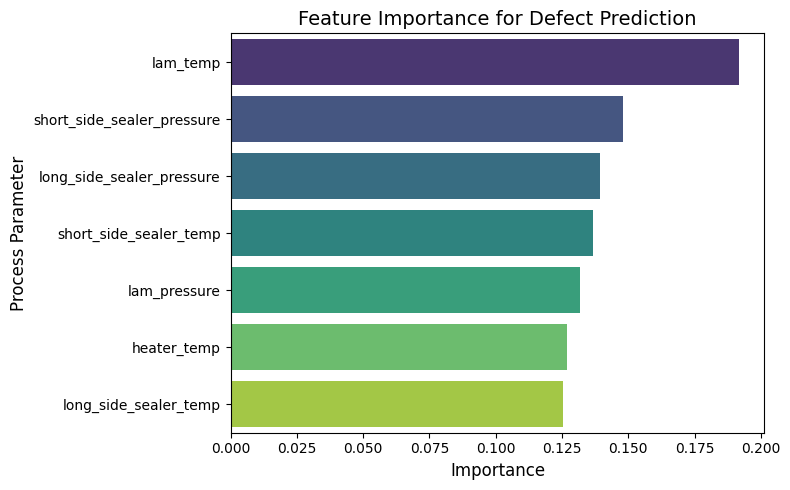

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Train Random Forest
# --------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# --------------------------
# Feature Importance Plot
# --------------------------
importances = model.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi_df = fi_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis")
plt.title("Feature Importance for Defect Prediction", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Process Parameter", fontsize=12)
plt.tight_layout()
plt.show()